In [1]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as img


%matplotlib inline

## Reading in X_train_array, X_test_array, y_train, y_test and df_comb

In [2]:
import h5py

/home/ubuntu/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
with h5py.File('./datasets/X_train_array.h5', 'r') as hf:
    X_train_array = hf['X_train_array'][:]

In [4]:
with h5py.File('./datasets/X_test_array.h5', 'r') as hf:
    X_test_array = hf['X_test_array'][:]

In [5]:
# reading in y_train as a DataFrame
y_train = pd.read_csv('./datasets/y_train.csv')

In [6]:
# reading in y_test as a DataFrame
y_test = pd.read_csv('./datasets/y_test.csv')

In [7]:
# reading in df_comb as a DataFrame
df_comb = pd.read_csv('./datasets/df_comb.csv')

In [8]:
X_train_array[0][128][128]

array([0.91764706, 0.79607843, 0.61176471])

In [9]:
y_train.head()

,modified
0,0
1,1
2,0
3,0
4,0


## Sample Photo From X_train

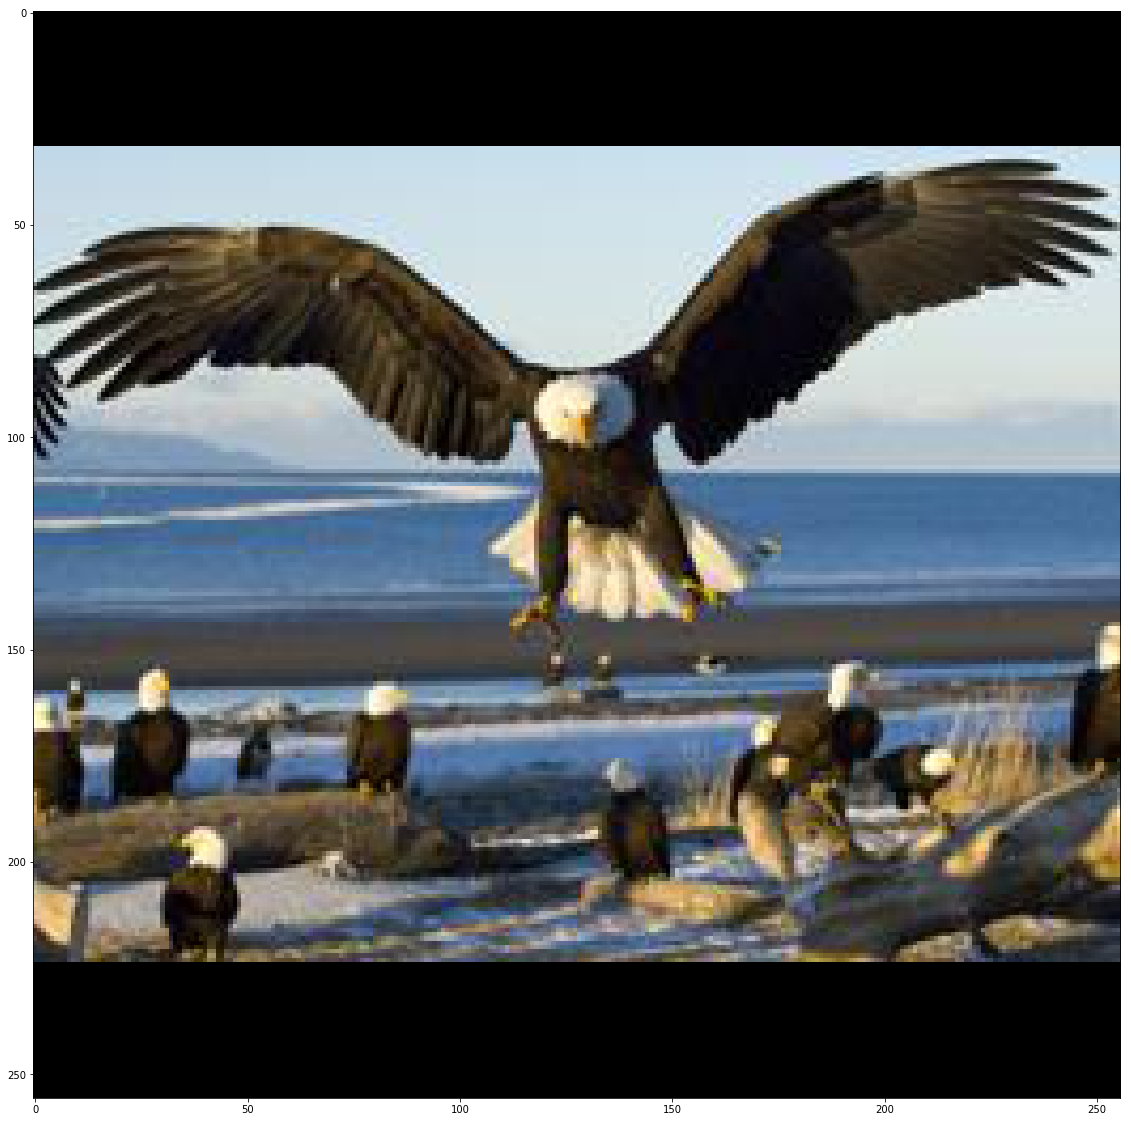

In [10]:
plt.figure(figsize = (30,20))
plt.imshow(X_train_array[0])
plt.show()

## Applying Template CNN Treatment

In [11]:
# !pip install keras
# !pip install tensorflow

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D
from keras.utils import np_utils

from keras.utils import Sequence

from sklearn.model_selection import train_test_split


Using TensorFlow backend.


## Object Creation for Batch Processing

In [12]:
class PhotoModSequence(Sequence):

    def __init__(self, x_set, y_set, batch_size):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size
        self.counter = 0

    def __len__(self):
        return int(np.ceil(len(self.x) / float(self.batch_size)))

    def __getitem__(self, idx):
        
        #print ('\nBatch #: ' + str(idx))
        #print ('From ' + str(idx*self.batch_size) + ' to ' + str((idx+1)*self.batch_size))
        
        
        batch_x = self.x[(idx) * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.y[(idx) * self.batch_size:(idx + 1) * self.batch_size]
        
        #print ('Returned batch size: ' + str(len(batch_x)))
        #self.counter += 1
        
        #return np.array([np.resize(img.imread(file_path), (1024, 1024,3))
        #          for file_path in batch_x]), np.array(batch_y)

        return np.array(batch_x), np.array(batch_y)

    

In [13]:
# Parameters to choose:

# choose actual batch size
chosen_batch_size = 250

# choose image size pixels height by pixels width by no. of color channels
max_allowable_pixels_height = 256
max_allowable_pixels_width = 256
color_channels = 3


In [14]:
training_set = PhotoModSequence(X_train_array, y_train, chosen_batch_size)

In [15]:
test_set = PhotoModSequence(X_test_array, y_test, chosen_batch_size)

## Creating Network

In [16]:
# instantiate model
model = Sequential()

model.add(Conv2D(32, (2, 2), activation='relu', input_shape=(max_allowable_pixels_height, max_allowable_pixels_width, color_channels)))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (2, 2), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))


model.add(Flatten())

model.add(Dense(32, activation='relu'))

# add dropout to reduce overfitting
model.add(Dropout(0.5))

# output layer
model.add(Dense(1, activation='sigmoid'))

In [17]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 255, 255, 32)      416       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 127, 127, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 126, 126, 64)      8256      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 63, 63, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 254016)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                8128544   
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)               

In [18]:
#checkpoint
from keras.callbacks import ModelCheckpoint
filepath = './weights/weights-{epoch:02d}-{val_accuracy:.2f}.hdf5'

#weights.{epoch:02d}-{val_loss:.2f}.hdf5

checkpoint = ModelCheckpoint(filepath, monitor = 'val_accuracy', verbose=1, save_best_only=False, save_weights_only=False, mode='auto',period=1)
callbacks_list = [checkpoint]

In [19]:
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [20]:
history = model.fit_generator(
    training_set,
    steps_per_epoch=np.ceil(len(X_train_array)/chosen_batch_size),
    epochs=50,
    validation_data = test_set,
    validation_steps=np.ceil(len(X_test_array)/chosen_batch_size),
    callbacks=callbacks_list)

Epoch 1/50
8/8 [==============================] - 32s 4s/step - loss: 2.1654 - accuracy: 0.4951 - val_loss: 0.7779 - val_accuracy: 0.5440

Epoch 00001: saving model to ./weights/weights-01-0.54.hdf5
Epoch 2/50
8/8 [==============================] - 31s 4s/step - loss: 0.7167 - accuracy: 0.5473 - val_loss: 0.6929 - val_accuracy: 0.5163

Epoch 00002: saving model to ./weights/weights-02-0.52.hdf5
Epoch 3/50
8/8 [==============================] - 31s 4s/step - loss: 0.6800 - accuracy: 0.5902 - val_loss: 0.6835 - val_accuracy: 0.5993

Epoch 00003: saving model to ./weights/weights-03-0.60.hdf5
Epoch 4/50
8/8 [==============================] - 31s 4s/step - loss: 0.6612 - accuracy: 0.5902 - val_loss: 0.6671 - val_accuracy: 0.5977

Epoch 00004: saving model to ./weights/weights-04-0.60.hdf5
Epoch 5/50
8/8 [==============================] - 31s 4s/step - loss: 0.6417 - accuracy: 0.6201 - val_loss: 0.6408 - val_accuracy: 0.6547

Epoch 00005: saving model to ./weights/weights-05-0.65.hdf5
Epoch

8/8 [==============================] - 32s 4s/step - loss: 0.2125 - accuracy: 0.9049 - val_loss: 0.4358 - val_accuracy: 0.8404

Epoch 00042: saving model to ./weights/weights-42-0.84.hdf5
Epoch 43/50
8/8 [==============================] - 32s 4s/step - loss: 0.2014 - accuracy: 0.9114 - val_loss: 0.4895 - val_accuracy: 0.8290

Epoch 00043: saving model to ./weights/weights-43-0.83.hdf5
Epoch 44/50
8/8 [==============================] - 32s 4s/step - loss: 0.2044 - accuracy: 0.9033 - val_loss: 0.4449 - val_accuracy: 0.8469

Epoch 00044: saving model to ./weights/weights-44-0.85.hdf5
Epoch 45/50
8/8 [==============================] - 32s 4s/step - loss: 0.1911 - accuracy: 0.9136 - val_loss: 0.4161 - val_accuracy: 0.8632

Epoch 00045: saving model to ./weights/weights-45-0.86.hdf5
Epoch 46/50
8/8 [==============================] - 32s 4s/step - loss: 0.1873 - accuracy: 0.9136 - val_loss: 0.4695 - val_accuracy: 0.8322

Epoch 00046: saving model to ./weights/weights-46-0.83.hdf5
Epoch 47/50


In [21]:
X_train_array.shape

(1840, 256, 256, 3)

In [22]:
X_test_array.shape

(614, 256, 256, 3)

In [23]:
# model has best val_acc after 38 epochs

In [25]:
# load model weights from the best model

# uncomment below code to use it as its weights as opposed to the final epoch's weights
# model.load_weights('./weights/weights-50-0.85.hdf5')

In [26]:
# predict test data
pred_test=model.predict_generator(test_set,steps=np.ceil(len(X_test_array)/chosen_batch_size),verbose=1)
#pred_test

3/3 [==============================] - 4s 1s/step


In [27]:
# predict training data
pred_train=model.predict_generator(training_set,steps=np.ceil(len(X_train_array)/chosen_batch_size),verbose=1)
#pred_train

8/8 [==============================] - 10s 1s/step


## Saving Weights and Model

In [28]:
from keras.models import model_from_json

In [29]:
# serialize model to JSON
model_json = model.to_json()
with open("./models/model_bootstrap_200_epochs_50_filter_2by2.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("./models/model_bootstrap_200_epochs_50_filter_2by2.h5")
print("Saved model to disk")

Saved model to disk


## Train Loss and Test Loss

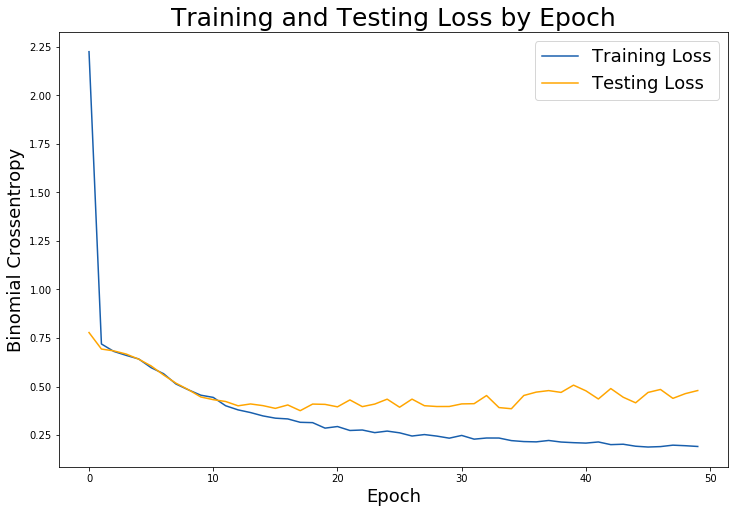

In [30]:
# Check out our train loss and test loss over epochs.
train_loss = history.history['loss']
test_loss = history.history['val_loss']

# Set figure size.
plt.figure(figsize=(12, 8))

# Generate line plot of training, testing loss over epochs.
plt.plot(train_loss, label='Training Loss', color='#185fad')
plt.plot(test_loss, label='Testing Loss', color='orange')

# Set title
plt.title('Training and Testing Loss by Epoch', fontsize = 25)
plt.xlabel('Epoch', fontsize = 18)
plt.ylabel('Binomial Crossentropy', fontsize = 18)


plt.legend(fontsize = 18);

## Train Accuracy and Test Accuracy

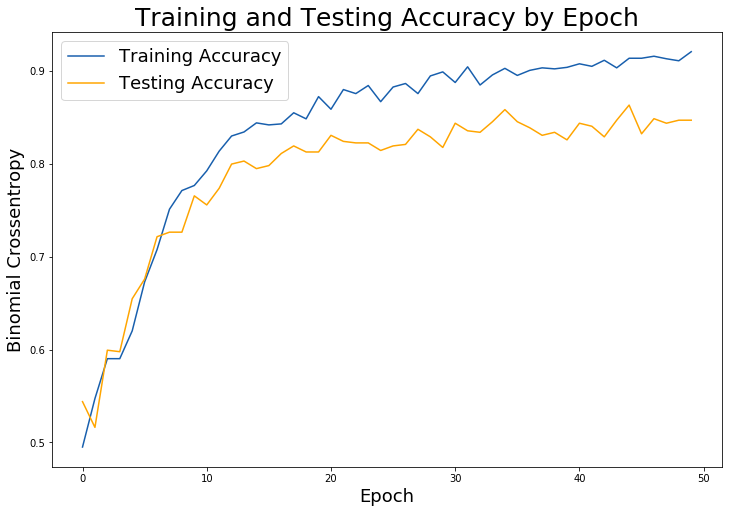

In [31]:
# Check out our train loss and test loss over epochs.
train_accuracy = history.history['accuracy']
test_accuracy = history.history['val_accuracy']

# Set figure size.
plt.figure(figsize=(12, 8))

# Generate line plot of training, testing loss over epochs.
plt.plot(train_accuracy, label='Training Accuracy', color='#185fad')
plt.plot(test_accuracy, label='Testing Accuracy', color='orange')

# Set title
plt.title('Training and Testing Accuracy by Epoch', fontsize = 25)
plt.xlabel('Epoch', fontsize = 18)
plt.ylabel('Binomial Crossentropy', fontsize = 18)


plt.legend(fontsize = 18);

## Baseline Accuracy of df_comb

In [32]:
# baseline accuracy predicting all cases to be majority class
max(df_comb['modified'].mean(), 1-df_comb['modified'].mean())

0.5330073349633252

## Train Accuracy and Test Accuracy

In [78]:
# Evaluate model on test data.
model_score = model.evaluate(X_train_array,
                                   y_train,
                                   verbose=1)

model_labels = model.metrics_names

1840/1840 [==============================] - 98s 53ms/step


In [79]:
print(f'Model {model_labels[0]}  : {model_score[0]}')
print(f'Model {model_labels[1]}   : {model_score[1]}')

Model loss  : 0.12074699466643127
Model accuracy   : 0.949999988079071


In [80]:
# Evaluate model on test data.
model_score = model.evaluate(X_test_array,
                                   y_test,
                                   verbose=1)

model_labels = model.metrics_names

614/614 [==============================] - 30s 49ms/step


In [81]:
print(f'Model {model_labels[0]}  : {model_score[0]}')
print(f'Model {model_labels[1]}   : {model_score[1]}')

Model loss  : 0.515614473907101
Model accuracy   : 0.846905529499054


## Train and Test Predictions

In [35]:
pred_class = model.predict_classes(X_train_array)
pred_proba = model.predict_proba(X_train_array)

#making empty dataframe
X_train_preds_df = pd.DataFrame(columns=['true_label'])

X_train_preds_df['true_label'] = y_train['modified']
X_train_preds_df['pred_label'] = pred_class
X_train_preds_df['probability'] = pred_proba

In [36]:
X_train_preds_df[0:25]

,true_label,pred_label,probability
0,0,0,0.405185
1,1,1,1.000000
2,0,0,0.010626
3,0,0,0.272199
4,0,0,0.366540
5,1,1,0.996006
6,1,1,0.999420
7,1,1,1.000000
8,0,0,0.000135
9,0,0,0.028217


In [37]:
pred_class = model.predict_classes(X_test_array)
pred_proba = model.predict_proba(X_test_array)

#making empty dataframe
X_test_preds_df = pd.DataFrame(columns=['true_label'])


X_test_preds_df['true_label'] = y_test['modified']
X_test_preds_df['pred_label'] = pred_class
X_test_preds_df['probability'] = pred_proba

In [38]:
X_test_preds_df[0:25]

,true_label,pred_label,probability
0,1,0,0.007147
1,1,0,0.080784
2,1,0,0.297488
3,1,0,0.000673
4,0,0,0.002752
5,1,1,0.995127
6,0,0,0.035915
7,1,1,0.655867
8,1,1,0.999999
9,1,0,0.001774


## Classification Metrics: Confusion Matrix, Sensitivity/Recall AUC ROC

In [39]:
from sklearn.metrics import confusion_matrix, classification_report

In [40]:
# Confusion Matrix
cm=confusion_matrix(y_test,pred_class)

In [41]:
cm

array([[269,  18],
       [ 76, 251]])

In [42]:
cm_df=pd.DataFrame(cm,columns=['pred_modified','pred_original'],index=['actual_modified','actual_original'])

In [43]:
cm_df

,pred_modified,pred_original
actual_modified,269,18
actual_original,76,251


In [44]:
# Recall

TP, TN, FP, FN = cm[0,0], cm[1,1], cm[1,0], cm[0,1]

In [45]:
recall = TP/(TP+FN)
recall

0.9372822299651568

In [46]:
# Type 1 errors are false positives

FP

76

In [47]:
# Type 2 errors are false negatives

FN

18

In [48]:
# Sensitivity/Recall

recall = TP/(TP+FN)
recall

0.9372822299651568

In [49]:
# Specificity

specificity = TN/(TN+FP)
specificity

0.7675840978593272

In [50]:
# Precision

precision = TP/(TP+FP)
precision

0.7797101449275362

In [51]:
# F1_Score

f1_score = (2 * precision * recall) / (precision + recall)
f1_score

0.8512658227848101

## Distribution of P(Outcome = 1)

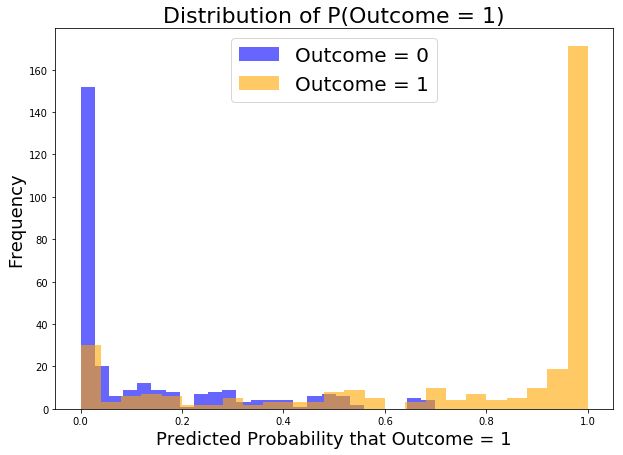

In [52]:
# Create figure.
plt.figure(figsize = (10,7))

# Create two histograms of observations.
plt.hist(X_test_preds_df[X_test_preds_df['true_label'] == 0]['probability'],
         bins=25,
         color='b',
         alpha = 0.6,
         label='Outcome = 0')
plt.hist(X_test_preds_df[X_test_preds_df['true_label'] == 1]['probability'],
         bins=25,
         color='orange',
         alpha = 0.6,
         label='Outcome = 1')

# Label axes.
plt.title('Distribution of P(Outcome = 1)', fontsize=22)
plt.ylabel('Frequency', fontsize=18)
plt.xlabel('Predicted Probability that Outcome = 1', fontsize=18)

# Create legend.
plt.legend(fontsize=20, loc='upper center');

## ROC Area Under Curve (AOC)

The more area under this blue curve is, the better separated our distributions are.


We use the **area under the ROC curve** (abbreviated **ROC AUC** or **AUC ROC**) to quantify the gap between our distributions.


In [53]:
# Import roc_auc_score.
from sklearn.metrics import roc_auc_score

In [54]:
# Calculate score.
roc_auc_score(X_test_preds_df['true_label'], X_test_preds_df['probability'])

0.9051721382220376

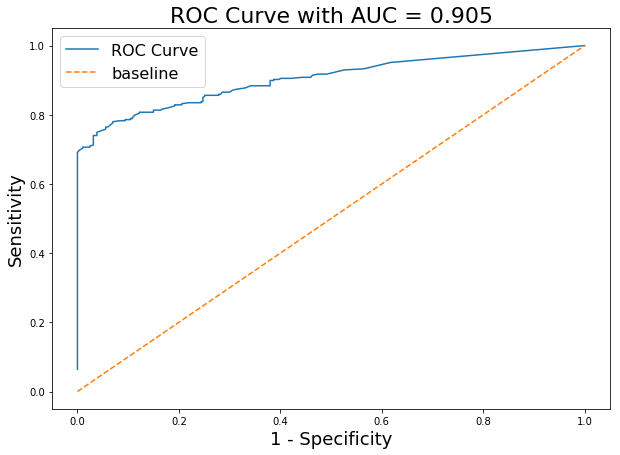

In [55]:
# Create figure.
plt.figure(figsize = (10,7))

# Create threshold values. (Dashed red line in image.)
thresholds = np.linspace(0, 1, 200)

# Define function to calculate sensitivity. (True positive rate.)
def TPR(df, true_col, pred_prob_col, threshold):
    true_positive = df[(df[true_col] == 1) & (df[pred_prob_col] >= threshold)].shape[0]
    false_negative = df[(df[true_col] == 1) & (df[pred_prob_col] < threshold)].shape[0]
    return true_positive / (true_positive + false_negative)
    
# Define function to calculate 1 - specificity. (False positive rate.)
def FPR(df, true_col, pred_prob_col, threshold):
    true_negative = df[(df[true_col] == 0) & (df[pred_prob_col] <= threshold)].shape[0]
    false_positive = df[(df[true_col] == 0) & (df[pred_prob_col] > threshold)].shape[0]
    return 1 - (true_negative / (true_negative + false_positive))
    
# Calculate sensitivity & 1-specificity for each threshold between 0 and 1.
tpr_values = [TPR(X_test_preds_df, 'true_label', 'probability', prob) for prob in thresholds]
fpr_values = [FPR(X_test_preds_df, 'true_label', 'probability', prob) for prob in thresholds]

# Plot ROC curve.
plt.plot(fpr_values, # False Positive Rate on X-axis
         tpr_values, # True Positive Rate on Y-axis
         label='ROC Curve')

# Plot baseline. (Perfect overlap between the two populations.)
plt.plot(np.linspace(0, 1, 200),
         np.linspace(0, 1, 200),
         label='baseline',
         linestyle='--')

# Label axes.
plt.title(f"ROC Curve with AUC = {round(roc_auc_score(X_test_preds_df['true_label'], X_test_preds_df['probability']),3)}", fontsize=22)
plt.ylabel('Sensitivity', fontsize=18)
plt.xlabel('1 - Specificity', fontsize=18)

# Create legend.
plt.legend(fontsize=16);

## Optimal Thresholds

In [56]:
from numpy import sqrt
from numpy import argmax
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, precision_recall_curve
from matplotlib import pyplot

## True Positive Rate vs False Positive Rate

Best Threshold=0.521476, G-Mean=0.852


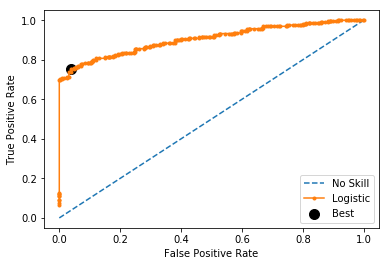

In [57]:
testX = X_test_array
testy = y_test



# predict probabilities
yhat = model.predict_proba(testX)

# keep probabilities for the positive outcome only
yhat = yhat[:, 0]

# calculate roc curves
fpr, tpr, thresholds = roc_curve(testy, yhat)

# calculate the g-mean for each threshold
gmeans = sqrt(tpr * (1-fpr))

# locate the index of the largest g-mean
ix = argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))

# plot the roc curve for the model
pyplot.plot([0,1], [0,1], linestyle='--', label='No Skill')
pyplot.plot(fpr, tpr, marker='.', label='Logistic')
pyplot.scatter(fpr[ix], tpr[ix], s=100, marker='o', color='black', label='Best')

# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.legend()

# show the plot
pyplot.show()

## Threshold for Precision vs Recall

Best Threshold=0.484920, F1-Score=0.847


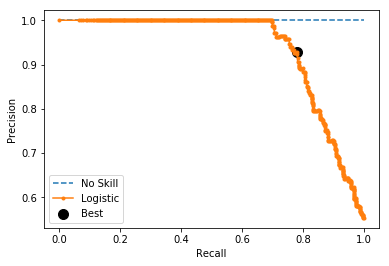

In [58]:
# calculate pr-curve
precision, recall, thresholds = precision_recall_curve(testy, yhat)
# convert to f score
f1score = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = argmax(f1score)
print('Best Threshold=%f, F1-Score=%.3f' % (thresholds[ix], f1score[ix]))
# plot the roc curve for the model
no_skill = len(testy[testy==1]) / len(testy)
pyplot.plot([0,1], [no_skill,no_skill], linestyle='--', label='No Skill')
pyplot.plot(recall, precision, marker='.', label='Logistic')
pyplot.scatter(recall[ix], precision[ix], s=100, marker='o', color='black', label='Best')
# axis labels
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
pyplot.legend()
# show the plot
pyplot.show()

## New Class Predictions based on New Threshold

In [59]:
new_pred_class = (model.predict_proba(X_test_array)[:,0] >= thresholds[ix]).astype(bool) # set threshold as thresholds[ix]


In [60]:
# Confusion Matrix
new_cm=confusion_matrix(y_test, new_pred_class)

In [61]:
new_cm

array([[267,  20],
       [ 72, 255]])

In [62]:
new_cm_df=pd.DataFrame(new_cm,columns=['pred_modified','pred_original'],index=['actual_modified','actual_original'])

In [63]:
new_cm_df

,pred_modified,pred_original
actual_modified,267,20
actual_original,72,255


In [64]:
# Recall

new_TP, new_TN, new_FP, new_FN = new_cm[0,0], new_cm[1,1], new_cm[1,0], new_cm[0,1]

In [65]:
new_recall = new_TP/(new_TP+new_FN)
new_recall

0.9303135888501742

In [66]:
# Type 1 errors are false positives

new_FP

72

In [67]:
# Type 2 errors are false negatives

new_FN

20

In [68]:
# Sensitivity/Recall

new_recall = new_TP/(new_TP+new_FN)
new_recall

0.9303135888501742

In [69]:
# Specificity

new_specificity = new_TN/(new_TN+new_FP)
new_specificity

0.7798165137614679

In [70]:
# Precision

new_precision = new_TP/(new_TP+new_FP)
new_precision

0.7876106194690266

In [71]:
# F1_Score

new_f1_score = (2 * new_precision * new_recall) / (new_precision + new_recall)
new_f1_score

0.853035143769968

## Single Image Prediction and Probability

In [72]:
true_label = (X_test_preds_df['true_label'][11])
true_label

0

In [73]:
pred_label = model.predict_classes((X_test_array[11]).reshape(1,256,256,3))
pred_label[0][0]

0

In [74]:
pred_proba = model.predict_proba((X_test_array[11]).reshape(1,256,256,3))
pred_proba[0][0]

0.44184196

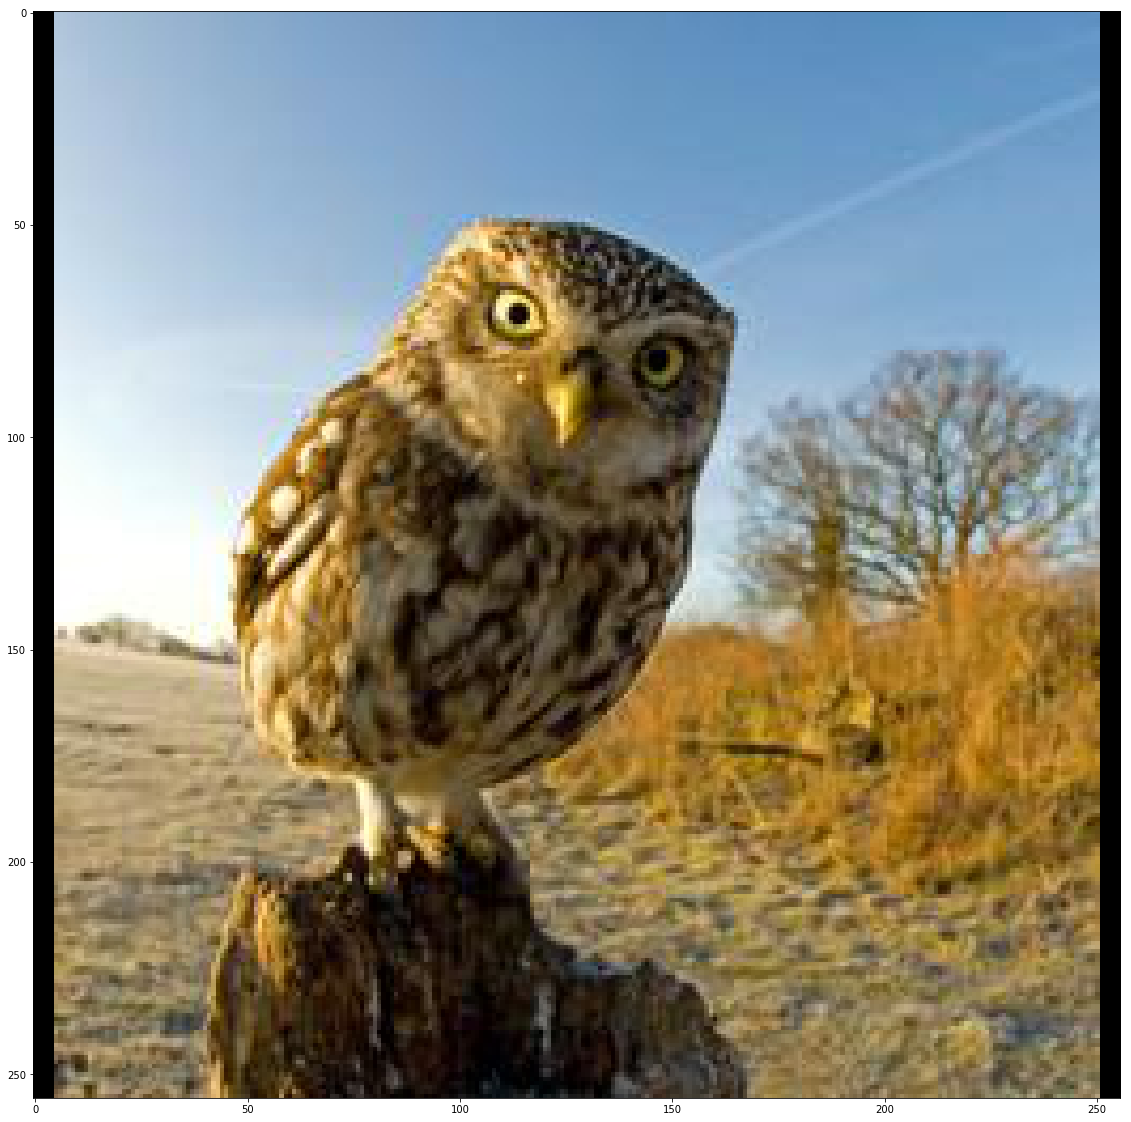

In [75]:
plt.figure(figsize = (30,20))
plt.imshow(X_test_array[11])
plt.show()